In [1]:
import sys
sys.path.append("..")
import itertools
from pathlib import Path
import pickle
from datetime import date

import pandas as pd
import numpy as np
from pandas.util.testing import assert_frame_equal
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.ar_model import AR, AutoReg, ar_select_order
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from btc_predictor.datasets import DataReader
from btc_predictor.utils import print_metrics

np.random.seed(78)

mpl.rcParams['figure.figsize'] = [16.0, 9.0]
np.random.seed(78)
%matplotlib inline
%load_ext autoreload
%autoreload 2

C:\Users\Han\.virtualenvs\btc_predictor-newMfeuI\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  # Remove the CWD from sys.path while we load stuff.


In [2]:
data = DataReader(data_file="../btc_predictor/datasets/Bitstamp_BTCUSD_d.csv")
df = data.pd

In [3]:
BTCUSD = df.copy()

BTCUSD['baseline_Close'] = BTCUSD.Close.shift(1)
BTCUSD['log_ret'] = np.log(BTCUSD.Close) - np.log(BTCUSD.Close.shift(1))
BTCUSD['baseline_log_ret'] = np.log(BTCUSD.baseline_Close) - np.log(BTCUSD.baseline_Close.shift(1))
BTCUSD.dropna(inplace=True)

# 1. Establishing Baseline

Due to the wild fluctuations of BTCUSD prices, from \$700s at the beginning of our data stream to \$10,000s towards the end, root mean squared error become an useless metric as the former erorr will miniscule compare to the later errors. Instead, we will look at the RMSE of the normalized and stationary log return.

In [4]:
print_metrics(y_true=BTCUSD.log_ret, y_pred=BTCUSD.baseline_log_ret)

Prediction RMSE: 0.0597,
              directional accuracy: 0.4724,
              mean directional accuracy: 0.3266


The loss is around 6%, which means the prior day return is an extremely great predictor of current day return. It would be hard to beat that. But the story will change if we look at the directions of the return. The direction of the return is more important than the magnitude of the return, i.e., a trade will be money losing when the direction is wrong.

As expected, the direction of prior day log returns is a poor predictor of the direction of current day log returns. While we can obsess with minimizing the RMSE to get a 'better' prediction, we won't be able to capitalize on that prediction until we get the direction right. Thus, it would be economically more important to obtain a better direction prediction than a better magnitude direction.

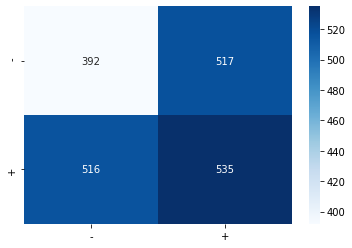

In [5]:
# remove zeros in log returns before plotting confusion matrix
zeros_idx = np.hstack([np.where(BTCUSD.log_ret == 0)[0], np.where(BTCUSD.baseline_log_ret==0)[0]]).tolist()

df_cm = pd.DataFrame(
    confusion_matrix(
        np.sign(np.delete(BTCUSD.log_ret.to_numpy(), zeros_idx)),
        np.sign(np.delete(BTCUSD.baseline_log_ret.to_numpy(), zeros_idx))
    ),
    index = [i for i in "-+"],
    columns = [i for i in "-+"],
)
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g');

## 2 Autoregressive (AR) Model

In [6]:
train = BTCUSD.iloc[-360:-30, :]['log_ret']
test = BTCUSD.iloc[-30:, :]['log_ret']

In [7]:
ar = AR(train, freq='D').fit()

y_pred = ar.predict(start=test.index[0], end=test.index[-1], dynamic=True)
assert len(y_pred) == test.shape[0]
print_metrics(y_true=test, y_pred=y_pred)

Prediction RMSE: 0.0340,
              directional accuracy: 0.5333,
              mean directional accuracy: 0.6207
C:\Users\Han\.virtualenvs\btc_predictor-newMfeuI\lib\site-packages\statsmodels\tsa\ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warn

In [8]:
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               AR Model Results                               
==============================================================================
Dep. Variable:                      l  -                  o                  g
Model:                         AR(16)   Log Likelihood                 515.368
Method:                          cmle   S.D. of innovations              0.047
Date:                Thu, 20 May 2021   AIC                             -6.006
Time:                        01:20:34   BIC                             -5.791
Sample:                    05-13-2019   HQIC                            -5.920
                         - 04-06-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0007      0.003     -0.253      0.800      -0.006       0.005
L1.log_ret     -0.1600      0.058     -2.748      0.006      -0.274      -0.046
L2.log_ret      0.0496      0.059      0.841      0.400      -0.066       0.165
L3.log_ret     -0.0206      0.059     -0.351      0.726      -0.136       0.094
L4.log_ret      0.1185      0.059      2.022      0.043       0.004       0.233
L5.log_ret     -0.0101      0.059     -0.171      0.864      -0.126       0.106
L6.log_ret     -0.0553      0.059     -0.936      0.349      -0.171       0.060
L7.log_ret     -0.0221      0.059     -0.373      0.709      -0.138       0.094
L8.log_ret     -0.0854      0.059     -1.440      0.150      -0.202       0.031
L9.log_ret     -0.0512      0.059     -0.863      0.388      -0.168       0.065
L10.log_ret     0.0202      0.059      0.343      0.731      -0.095       0.136
L11.log_ret    -0.0524      0.059     -0.887      0.375      -0.168       0.063
L12.log_ret     0.0207      0.059      0.353      0.724      -0.094       0.136
L13.log_ret     0.0402      0.058      0.691      0.490      -0.074       0.154
L14.log_ret     0.0023      0.058      0.040      0.968      -0.112       0.117
L15.log_ret     0.0376      0.059      0.638      0.523      -0.078       0.153
L16.log_ret     0.0284      0.058      0.491      0.624      -0.085       0.142
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0442           -0.4486j            1.1365           -0.0646
AR.2             1.0442           +0.4486j            1.1365            0.0646
AR.3             1.2209           -0.0000j            1.2209           -0.0000
AR.4             0.8193           -0.9589j            1.2613           -0.1375
AR.5             0.8193           +0.9589j            1.2613            0.1375
AR.6             0.3993           -1.1932j            1.2583           -0.1986
AR.7             0.3993           +1.1932j            1.2583            0.1986
AR.8            -0.0156           -1.2502j            1.2503           -0.2520
AR.9            -0.0156           +1.2502j            1.2503            0.2520
AR.10           -0.4645           -1.0791j            1.1748           -0.3147
AR.11           -0.4645           +1.0791j            1.1748            0.3147
AR.12           -1.0030           -0.6996j            1.2228           -0.4031
AR.13           -1.0030           +0.6996j            1.2228            0.4031
AR.14           -1.3066           -0.0000j            1.3066           -0.5000
AR.15           -1.4001           -0.3797j            1.4507           -0.4579
AR.16           -1.4001           +0.3797j            1.4507            0.4579
-------------------------------------------------------------

## 3. Univariate Autoregressive integrated Moving Average (ARIMA) Model

With AR(16), let's try to see if we can fit a better model using ARIMA. We will do it using pmdarima, a wrapper module over statsmodels with auto_arima model search capability to simplify the parameter search.

In [9]:
stepwise_arima = auto_arima(train, start_p=0, start_q=0, max_d=5,
                           max_p=16, max_q=5, m=12, scoring='mse',
                           start_P=0, max_order=20, random_state=78, seasonal=False,
                           d=1, D=1, trace=True, information_criterion='aic',
                           error_action='ignore', stationary=False, 
                           suppress_warnings=True, with_intercept=False,
                           stepwise=True, maxiter=100, n_jobs=24)

C:\Users\Han\.virtualenvs\btc_predictor-newMfeuI\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\Han\.virtualenvs\btc_predictor-newMfeuI\lib\site-packages\pmdarima\arima\_validation.py:77: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-779.740, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-923.583, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-954.433, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-992.789, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-1001.158, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=-1004.503, Time=0.19 sec
 A

In [10]:
stepwise_arima.fit(train)
stepwise_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  330
Model:               SARIMAX(6, 1, 0)   Log Likelihood                 510.980
Date:                Thu, 20 May 2021   AIC                          -1007.960
Time:                        01:20:41   BIC                           -981.387
Sample:                             0   HQIC                          -997.359
                                - 330                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9956      0.032    -31.345      0.000      -1.058      -0.933
ar.L2         -0.7894      0.069    -11.430      0.000      -0.925      -0.654
ar.L3         -0.6700      0.078     -8.538      0.000      -0.824      -0.516
ar.L4         -0.4015      0.071     -5.661      0.000      -0.541      -0.263
ar.L5         -0.2578      0.061     -4.214      0.000      -0.378      -0.138
ar.L6         -0.1306      0.032     -4.030      0.000      -0.194      -0.067
sigma2         0.0026   8.71e-05     29.972      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6394.02
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                            -2.06
Prob(H) (two-sided):                  0.04   Kurtosis:                        24.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Han\.virtualenvs\btc_predictor-newMfeuI\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


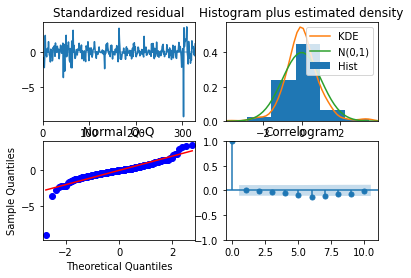

In [11]:
stepwise_arima.plot_diagnostics();

In [12]:
walk_forward, walk_forward_conf_int = stepwise_arima.predict(n_periods=7, return_conf_int=True)
print_metrics(y_true=test[:7], y_pred=walk_forward)

Prediction RMSE: 0.0384,
              directional accuracy: 0.4286,
              mean directional accuracy: 0.5000


C:\Users\Han\.virtualenvs\btc_predictor-newMfeuI\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.


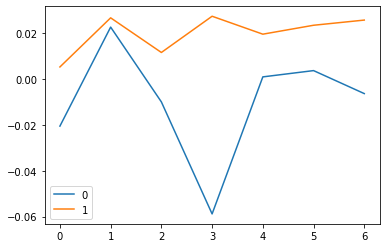

In [13]:
dd = pd.DataFrame(pd.np.column_stack([test[:7], walk_forward])).plot()

It seems like the predictive power quickly diminishes to just using last price after a few forward periods. Thus, we would have to do online updates to our ARIMA model, by using model.`update(new_data)`.

In [14]:
today = date.today().strftime('%Y%m%d')
mse = np.sqrt(mean_squared_error(test[:7], walk_forward))
acc = accuracy_score(np.sign(test[:7]), np.sign(walk_forward))
file_name = f'arima_{today}_{mse:.3f}_{acc:.3f}.pkl'
with open(file_name, 'wb') as pkl:
    pickle.dump(file_name, pkl)